In [1]:
import numpy as np
import scanpy, scprep, phate, magic
import leidenalg
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import SPARC
import seaborn as sns
from collections import defaultdict, Counter
import SpatialDE

In [2]:
scanpy.set_figure_params(dpi_save=500)

In [4]:
adata = scanpy.read_h5ad('data/V1_Human_Lymph_Node/processed.h5ad')

In [4]:
results = np.load('results/GSPA_QR.npz', allow_pickle=True)

In [5]:
phate_op = phate.PHATE(random_state=42)
data_phate = phate_op.fit_transform(results['signal_embedding'])

Calculating PHATE...
  Running PHATE on 1969 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.22 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.11 seconds.
  Calculated graph and diffusion operator in 0.80 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 1.87 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.61 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.59 seconds.
Calculated PHATE in 7.90 seconds.


### gene clusters

In [125]:
gene_clusters = np.array(leidenalg.find_partition(phate_op.graph.to_igraph(), 
                                                  leidenalg.ModularityVertexPartition,
                                                  seed=0).membership)

In [200]:
conv = {0:0, 1:1, 2:2, 3:1, 4:3, 5:2, 6:4, 7:5}
gene_clusters = [conv[x] for x in gene_clusters]

<AxesSubplot:title={'center':'Gene clusters'}, xlabel='Gene PHATE1', ylabel='Gene PHATE2'>

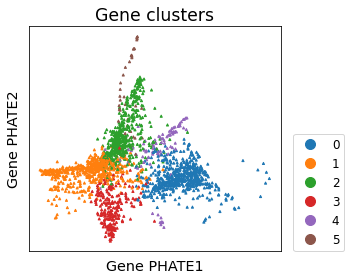

In [215]:
scprep.plot.scatter2d(data_phate, ticks=None, figsize=(5,4), c=gene_clusters, dpi=200, filename='figures/gene_clusters.png',
                          title='Gene clusters', label_prefix='Gene PHATE', legend_loc=(1.05,0), marker='^')

In [217]:
gene_summary = pd.concat((gene_clusters, pd.Series(results['localization_score'], index=results['genes'])), axis=1)
gene_summary.columns = ['gene_clusters', 'localization_score']
adata_ensembl_hvgs = adata.var.loc[gene_summary.index]['gene_ids'].values
gene_summary['ensembl'] = adata_ensembl_hvgs
gene_summary.to_csv('results/gene_summary.csv')

### visualize

In [8]:
gene_summary = pd.read_csv('results/gene_summary.csv', index_col=0)

In [13]:
sparc_op = SPARC.spARC(n_jobs=-1, random_state=42)
data_sparc = sparc_op.fit_transform(expression_X = adata.to_df(),
                                    spatial_X = adata.obs[['array_row', 'array_col']], )
adata.layers['X_sparc'] = data_sparc.values

Calculating spARC...
  Calculating PCA...
  Calculated PCA in 3.64 seconds.
  Calculating expression graph...
  Calculated expression graph in 0.90 seconds.
  Calculating spatial graph...
  Calculated spatial graph in 1.51 seconds.
  Calculating random walks on expression graph...
  Calculated random walks on expression graph in 0.67 seconds.
  Calculating random walks on spatial graph...
  Calculating spARCed expression data...
  Calculated spARCed expression data in 1.76 seconds.
Calculated spARC in 8.49 seconds.


In [15]:
for clust in range(gene_summary['gene_clusters'].max() + 1):
    adata.obs[f'Gene_cluster_{clust}'] = (scale(data_sparc[gene_summary.index].iloc[:, (gene_summary['gene_clusters'] == clust).values]).mean(axis=1))

Gene cluster 0: Blood vessel  
Gene cluster 1: Germinal Center  
Gene cluster 2: T cell zone  
Gene cluster 3: B follicule  
Gene cluster 4: B plasma-enriched region  
Gene cluster 5: B-ifn-enriched region  

In [85]:
adata.write('./data/V1_Human_Lymph_Node/processed.h5ad')

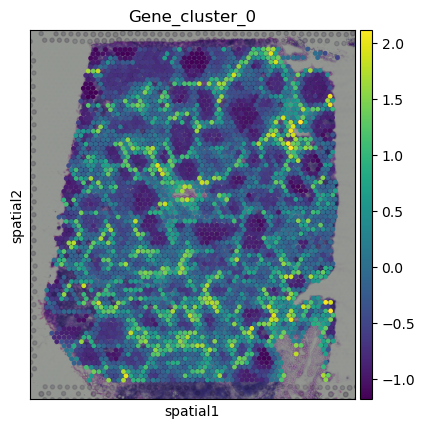

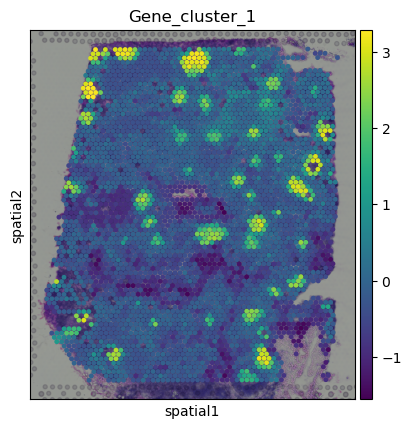

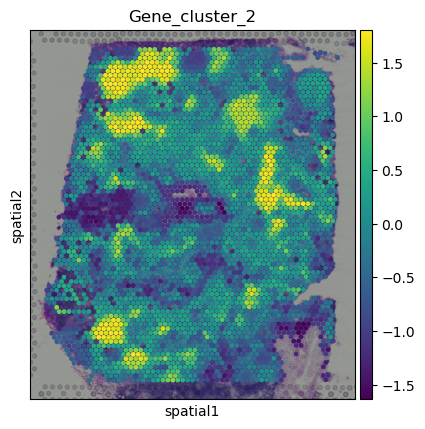

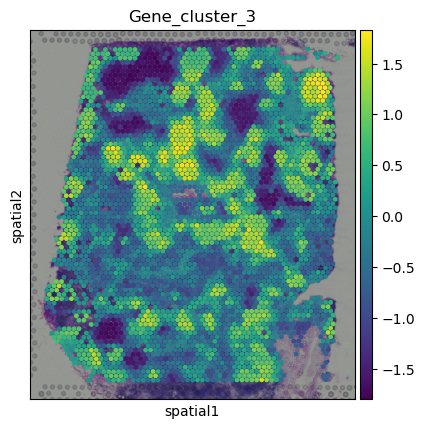

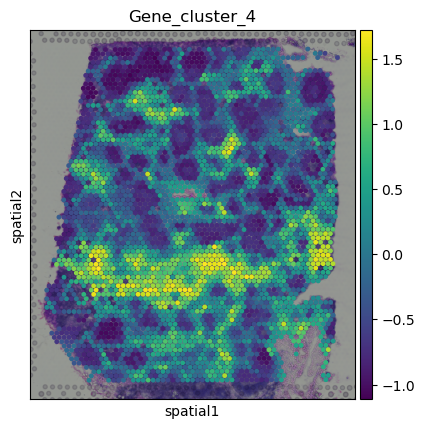

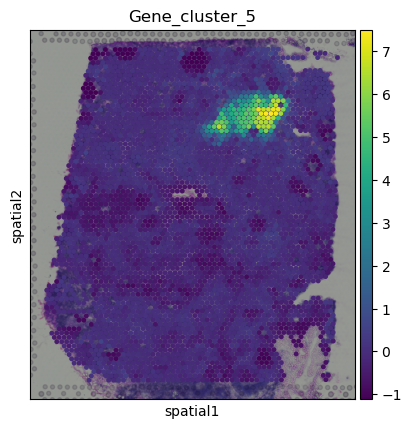

In [16]:
for clust in range(gene_summary['gene_clusters'].max() + 1):
    scanpy.pl.spatial(adata, color=[f'Gene_cluster_{clust}'], alpha_img=1, size=1.5, save=f'{clust}.png')

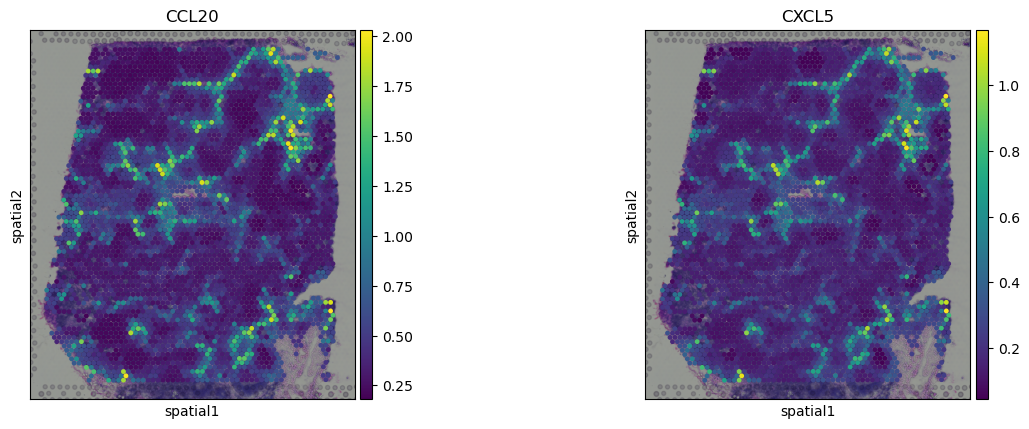

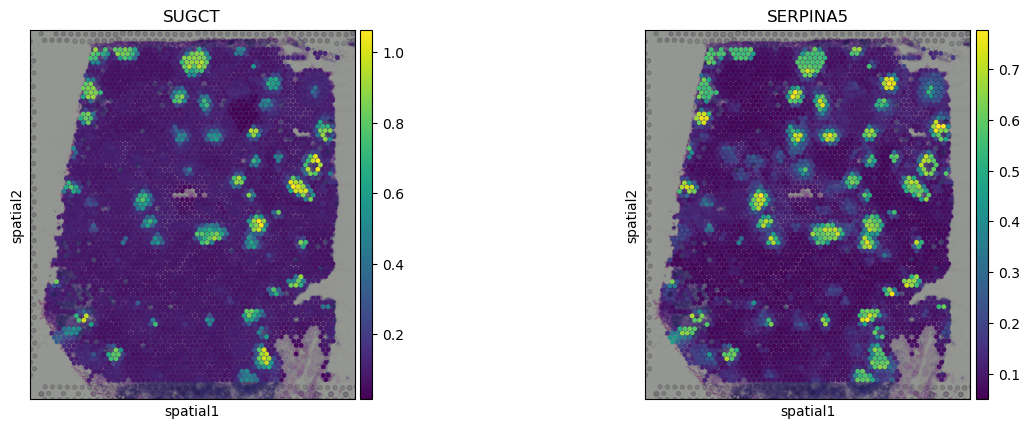

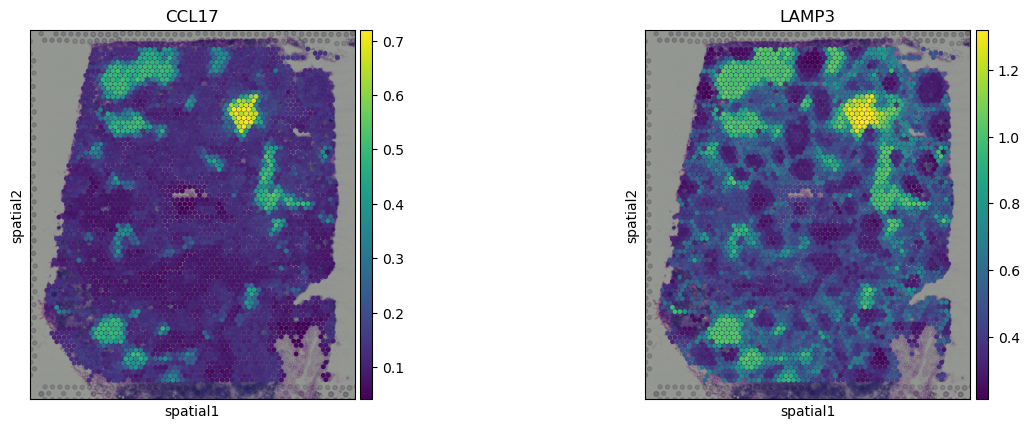

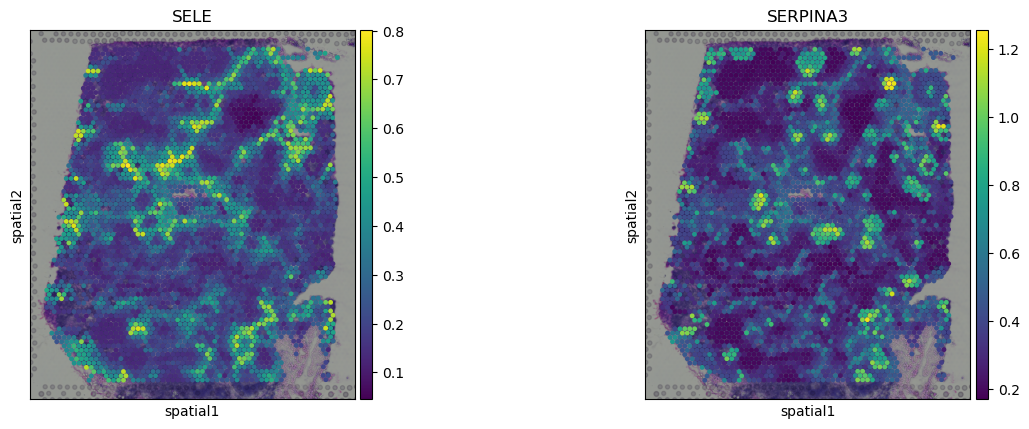

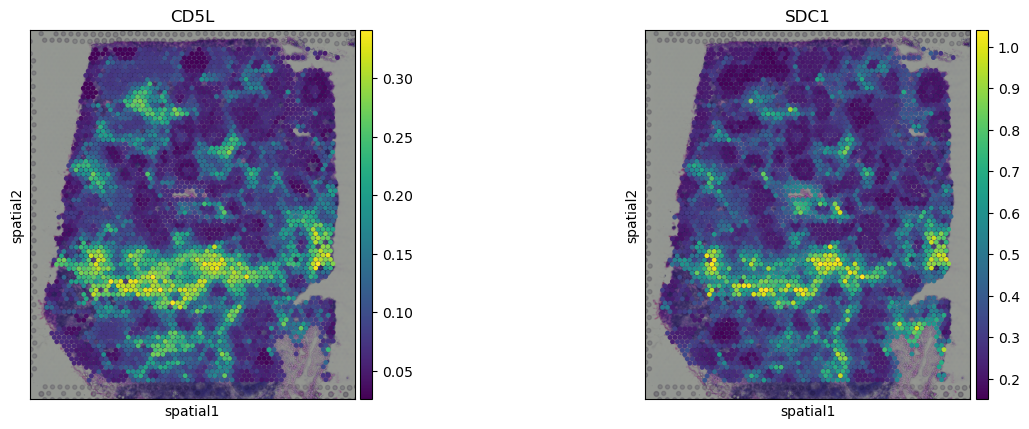

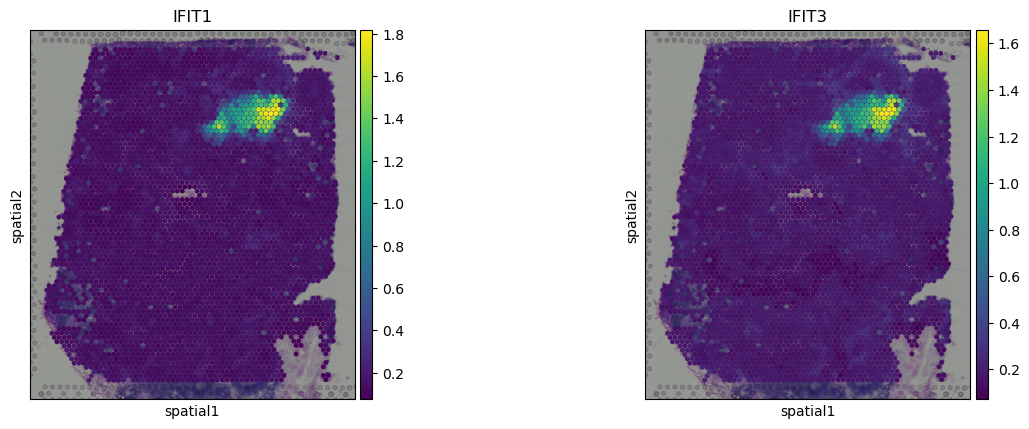

In [34]:
for clust in range(gene_summary['gene_clusters'].max() + 1):
    top_genes = gene_summary[gene_summary['gene_clusters'] == clust].sort_values(by='localization_score')[::-1].index[:2]
    scanpy.pl.spatial(adata, color=top_genes, alpha_img=1, size=1.5, save=f'top_genes_{clust}.png', layer='X_sparc')